# Import Required Packages

In [2]:
import sys
import numpy as np
import pandas as pd
sys.path.append('../src/neural_network')
from predict import *

# Loading Example Trajectories

In [3]:
trajectory1 = pd.read_csv('trajectory_1.csv')
trajectory2 = pd.read_csv('trajectory_2.csv')
trajectory3 = pd.read_csv('trajectory_3.csv')

# Visualization Functions

In [4]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, LineString
import contextily as ctx

def format_duration(seconds, unit='sec'):
    """
    Display time duration in HH:MM:SS or MM:SS format.
    
    Parameters:
    - seconds: The time in seconds or minutes.
    - unit: The unit of the input time ('sec' for seconds, 'min' for minutes).

    Returns:
    - A string representation of the time in either HH:MM:SS or MM:SS format.
    """
    
    if unit == 'min':
        seconds *= 60
    
    if np.isnan(seconds):
        return np.nan
    
    hours = 0
    if seconds >= 60*60:
        hours = seconds // (60*60)
        seconds %= (60*60)
    
    minutes = seconds // 60
    seconds %= 60
    
    if hours:
        return f"{int(hours):02}:{int(minutes):02}:{int(seconds):02}"
    else:
        return f"{int(minutes):02}:{int(seconds):02}"

def plot_gps_route(ax,
                   GPS_df,
                   trip_ID=None,
                   label='y_hat_labels',
                   n_driving_points=30,
                   col_lat='lat',
                   col_lon='lon',
                   title='',
                   basemap=True,
                   ax_legend=True):
    
    if trip_ID is not None:
        trip_test = GPS_df[GPS_df['TripId']==trip_ID].reset_index(drop=True).reset_index()
    else:
        trip_test = GPS_df


    gdf=gpd.GeoDataFrame(data=trip_test,
                         geometry=trip_test[[col_lat, col_lon]]\
                             .apply(lambda x: Point(x[col_lon], x[col_lat]), axis=1).values,
                         crs='EPSG:4326')


    idx_drive_max = gdf[gdf['y_hat_labels']=='driving'].iloc[-1].name

    ## route points
    gdf[gdf[f'{label}']=='driving'][idx_drive_max-n_driving_points:]\
            .to_crs('EPSG:3857').plot(ax=ax, color='blue', label='Driving',zorder=2)
    gdf[gdf[f'{label}']=='searching'].to_crs('EPSG:3857').plot(ax=ax, color='tab:red', label='Searching')

    ## route lines
    begin_loc_search = gdf[gdf[f'{label}']=='searching'].iloc[0].name
    gpd.GeoDataFrame(geometry=[LineString(gdf[idx_drive_max-n_driving_points:begin_loc_search+1]['geometry'].values)],
                     crs='epsg:4326').to_crs('EPSG:3857').plot(ax=ax, color='tab:blue')
    gpd.GeoDataFrame(geometry=[LineString(gdf[gdf[f'{label}']=='searching']['geometry'].values)],
                     crs='epsg:4326').to_crs('EPSG:3857').plot(ax=ax, color='tab:red')

    ## main points
    # gdf.iloc[[0]].to_crs('EPSG:3857').plot(color='blue',edgecolor='black', markersize=200, ax=ax,lw=3, label='Origin')
    gdf[gdf[f'{label}']=='searching'].iloc[[0]].to_crs('EPSG:3857').plot(ax=ax, edgecolor='black',lw=3, zorder=2,
                                                   markersize=350,color='red', label='Search Starting Point')
    gdf[gdf[f'{label}']=='searching'].iloc[[-1]].to_crs('EPSG:3857').plot(ax=ax, edgecolor='black',lw=3, zorder=2,
                                                    label='Parking Spot',markersize=350,color='tab:orange')


    xlim=ax.get_xlim()
    ylim=ax.get_ylim()

    ax.set_xlim([xlim[0]-10,xlim[1]+10])
    ax.set_ylim([ylim[0],ylim[1]+10])
    ax.set_axis_off()
    if ax_legend:
        ax.legend()

    psd_tmp = gdf[gdf[label] == "searching"]['remainingTime'].iloc[0]

    ax.set_title(f'{title}\nParking Search Duration: {format_duration(psd_tmp)}')
    
    if basemap:
        ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)
        #ctx.add_basemap(ax,source=ctx.providers.CartoDB.Voyager)
        #ctx.add_basemap(ax,source=ctx.providers.OpenStreetMap.Mapnik)

import folium

def visualize_trip(df, tripID=None, label='label'):
    
    if tripID!=None:     
        # Filter the dataframe for the specific tripID
        trip_data = df[df['TripID'] == tripID]
    else:
        trip_data=df

    # Colors based on label
    color_map = {
        'driving': 'blue',
        'searching': 'red',
        'walking': 'green'
    }

    # Use the last point as the center
    last_point = trip_data.iloc[-1]
    m = folium.Map(location=[last_point['lat'], last_point['lon']], zoom_start=15)

    # Iterate through the rows in trip_data and add markers to the map
    for _, row in trip_data.iterrows():
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=5,  # Adjust this as needed to change the size of the circle markers
            popup=f"Speed: {row['speed_kmh']}",
            color=color_map[row[label]],
            fill=True,
            fill_color=color_map[row[label]],
            fill_opacity=1.0
        ).add_to(m)

    return m

# Single Trajectory

**Example 1:**

In [6]:
traj1_pred = park_search_predict(trajectory1, 
                                 model_path='../model/ParkingSearchPrediction.h5',
                                 col_ID=None,
                                 col_time='timestamp',
                                 col_speed='speed_kmh',
                                 col_lat='lat',
                                 col_lon='lon',
                                 verbose=1)

3/3 [==============================] - 0s 6ms/step


In [7]:
traj1_pred.head()

lon        lat           timestamp  speed_kmh    label   
0  8.677233  50.130181 2021-02-22 20:11:11   0.000000  driving  \
1  8.677274  50.130207 2021-02-22 20:11:39   4.195406  driving   
2  8.677753  50.130292 2021-02-22 20:11:45  20.599526  driving   
3  8.678072  50.130509 2021-02-22 20:11:51  19.489262  driving   
4  8.678317  50.130747 2021-02-22 20:11:57  16.513604  driving   

   distToParkingSpot  samplingRate  remainingTime   y_hat_p y_hat_labels  
0         972.423844           0.0          489.0  0.004500      driving  
1         975.011992          28.0          461.0  0.006216      driving  
2         981.721493           6.0          455.0  0.003959      driving  
3        1004.692344           6.0          449.0  0.005176      driving  
4        1030.645062           6.0          443.0  0.005365      driving

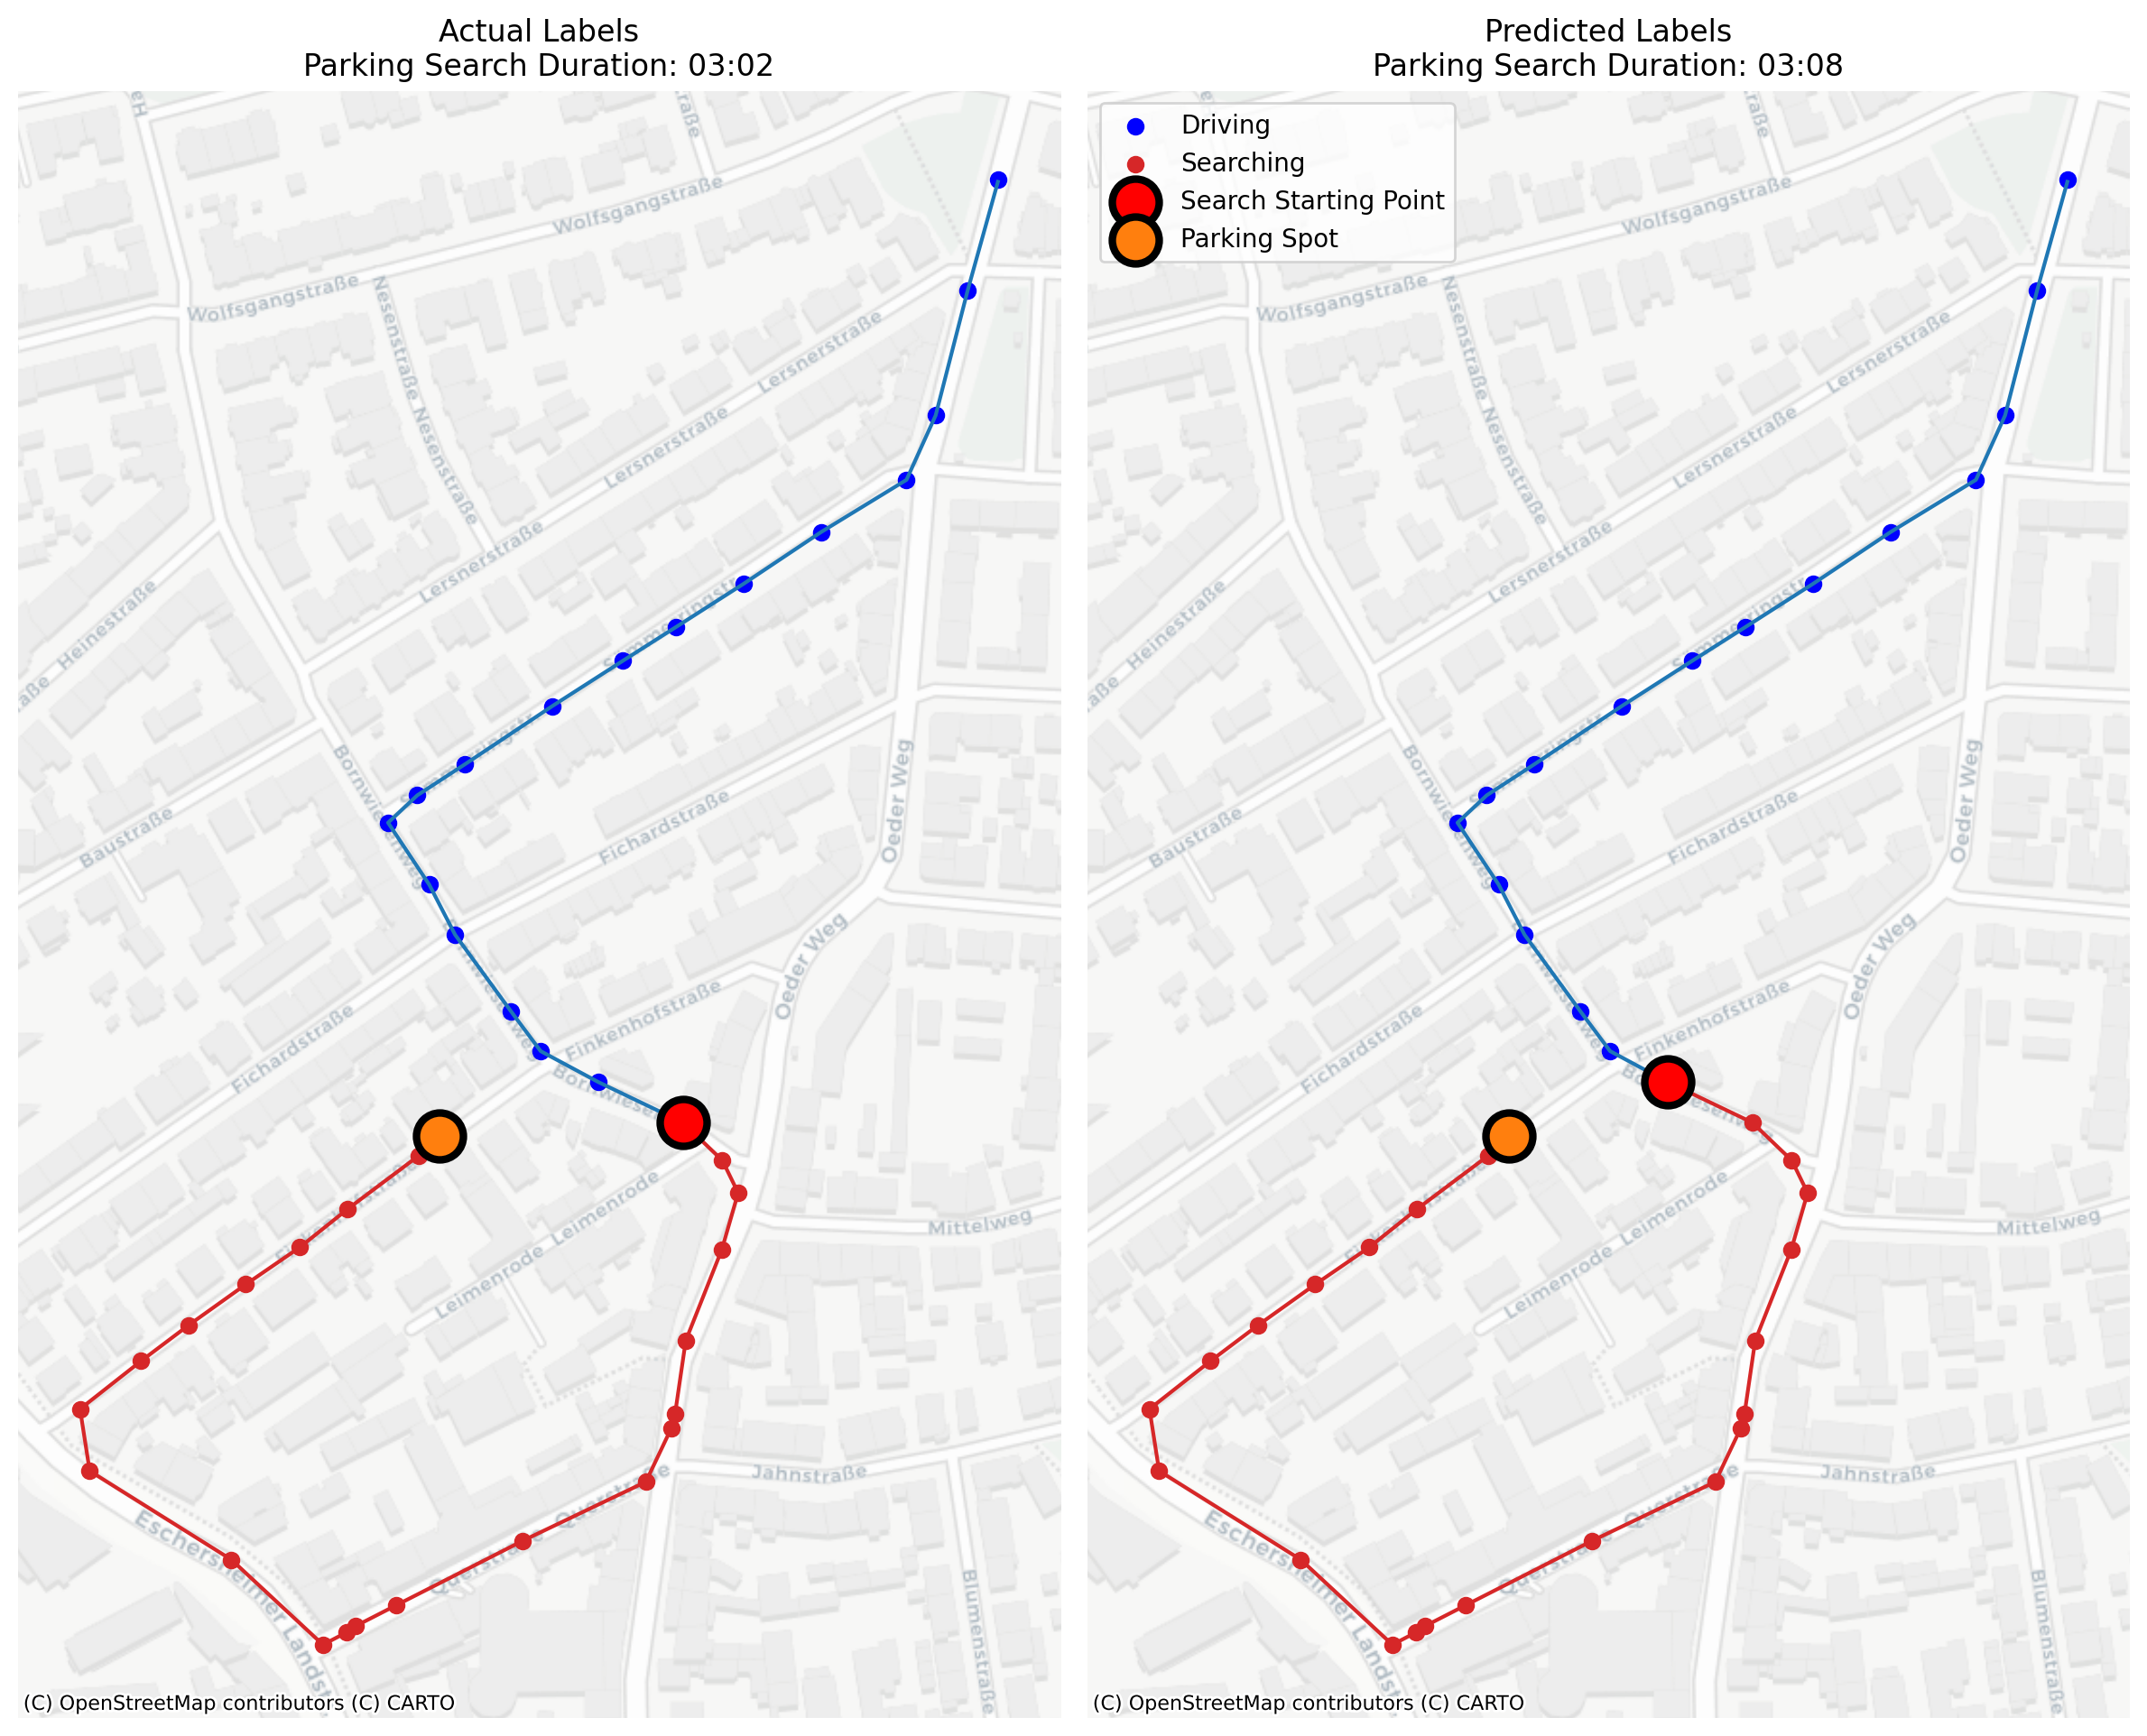

In [8]:
fig, axs = plt.subplots(1,2, figsize=(12,12), dpi=200)
plot_gps_route(axs[0], traj1_pred, n_driving_points=15, label='label', title='Actual Labels', ax_legend=False)
plot_gps_route(axs[1], traj1_pred, n_driving_points=15, label='y_hat_labels', title='Predicted Labels')
plt.tight_layout()

**Example 2:**

In [9]:
traj2_pred = park_search_predict(trajectory2, 
                                 model_path='../model/ParkingSearchPrediction.h5',
                                 col_ID=None,
                                 col_time='timestamp',
                                 col_speed='speed_kmh',
                                 col_lat='lat',
                                 col_lon='lon',
                                 verbose=1)

4/4 [==============================] - 0s 2ms/step


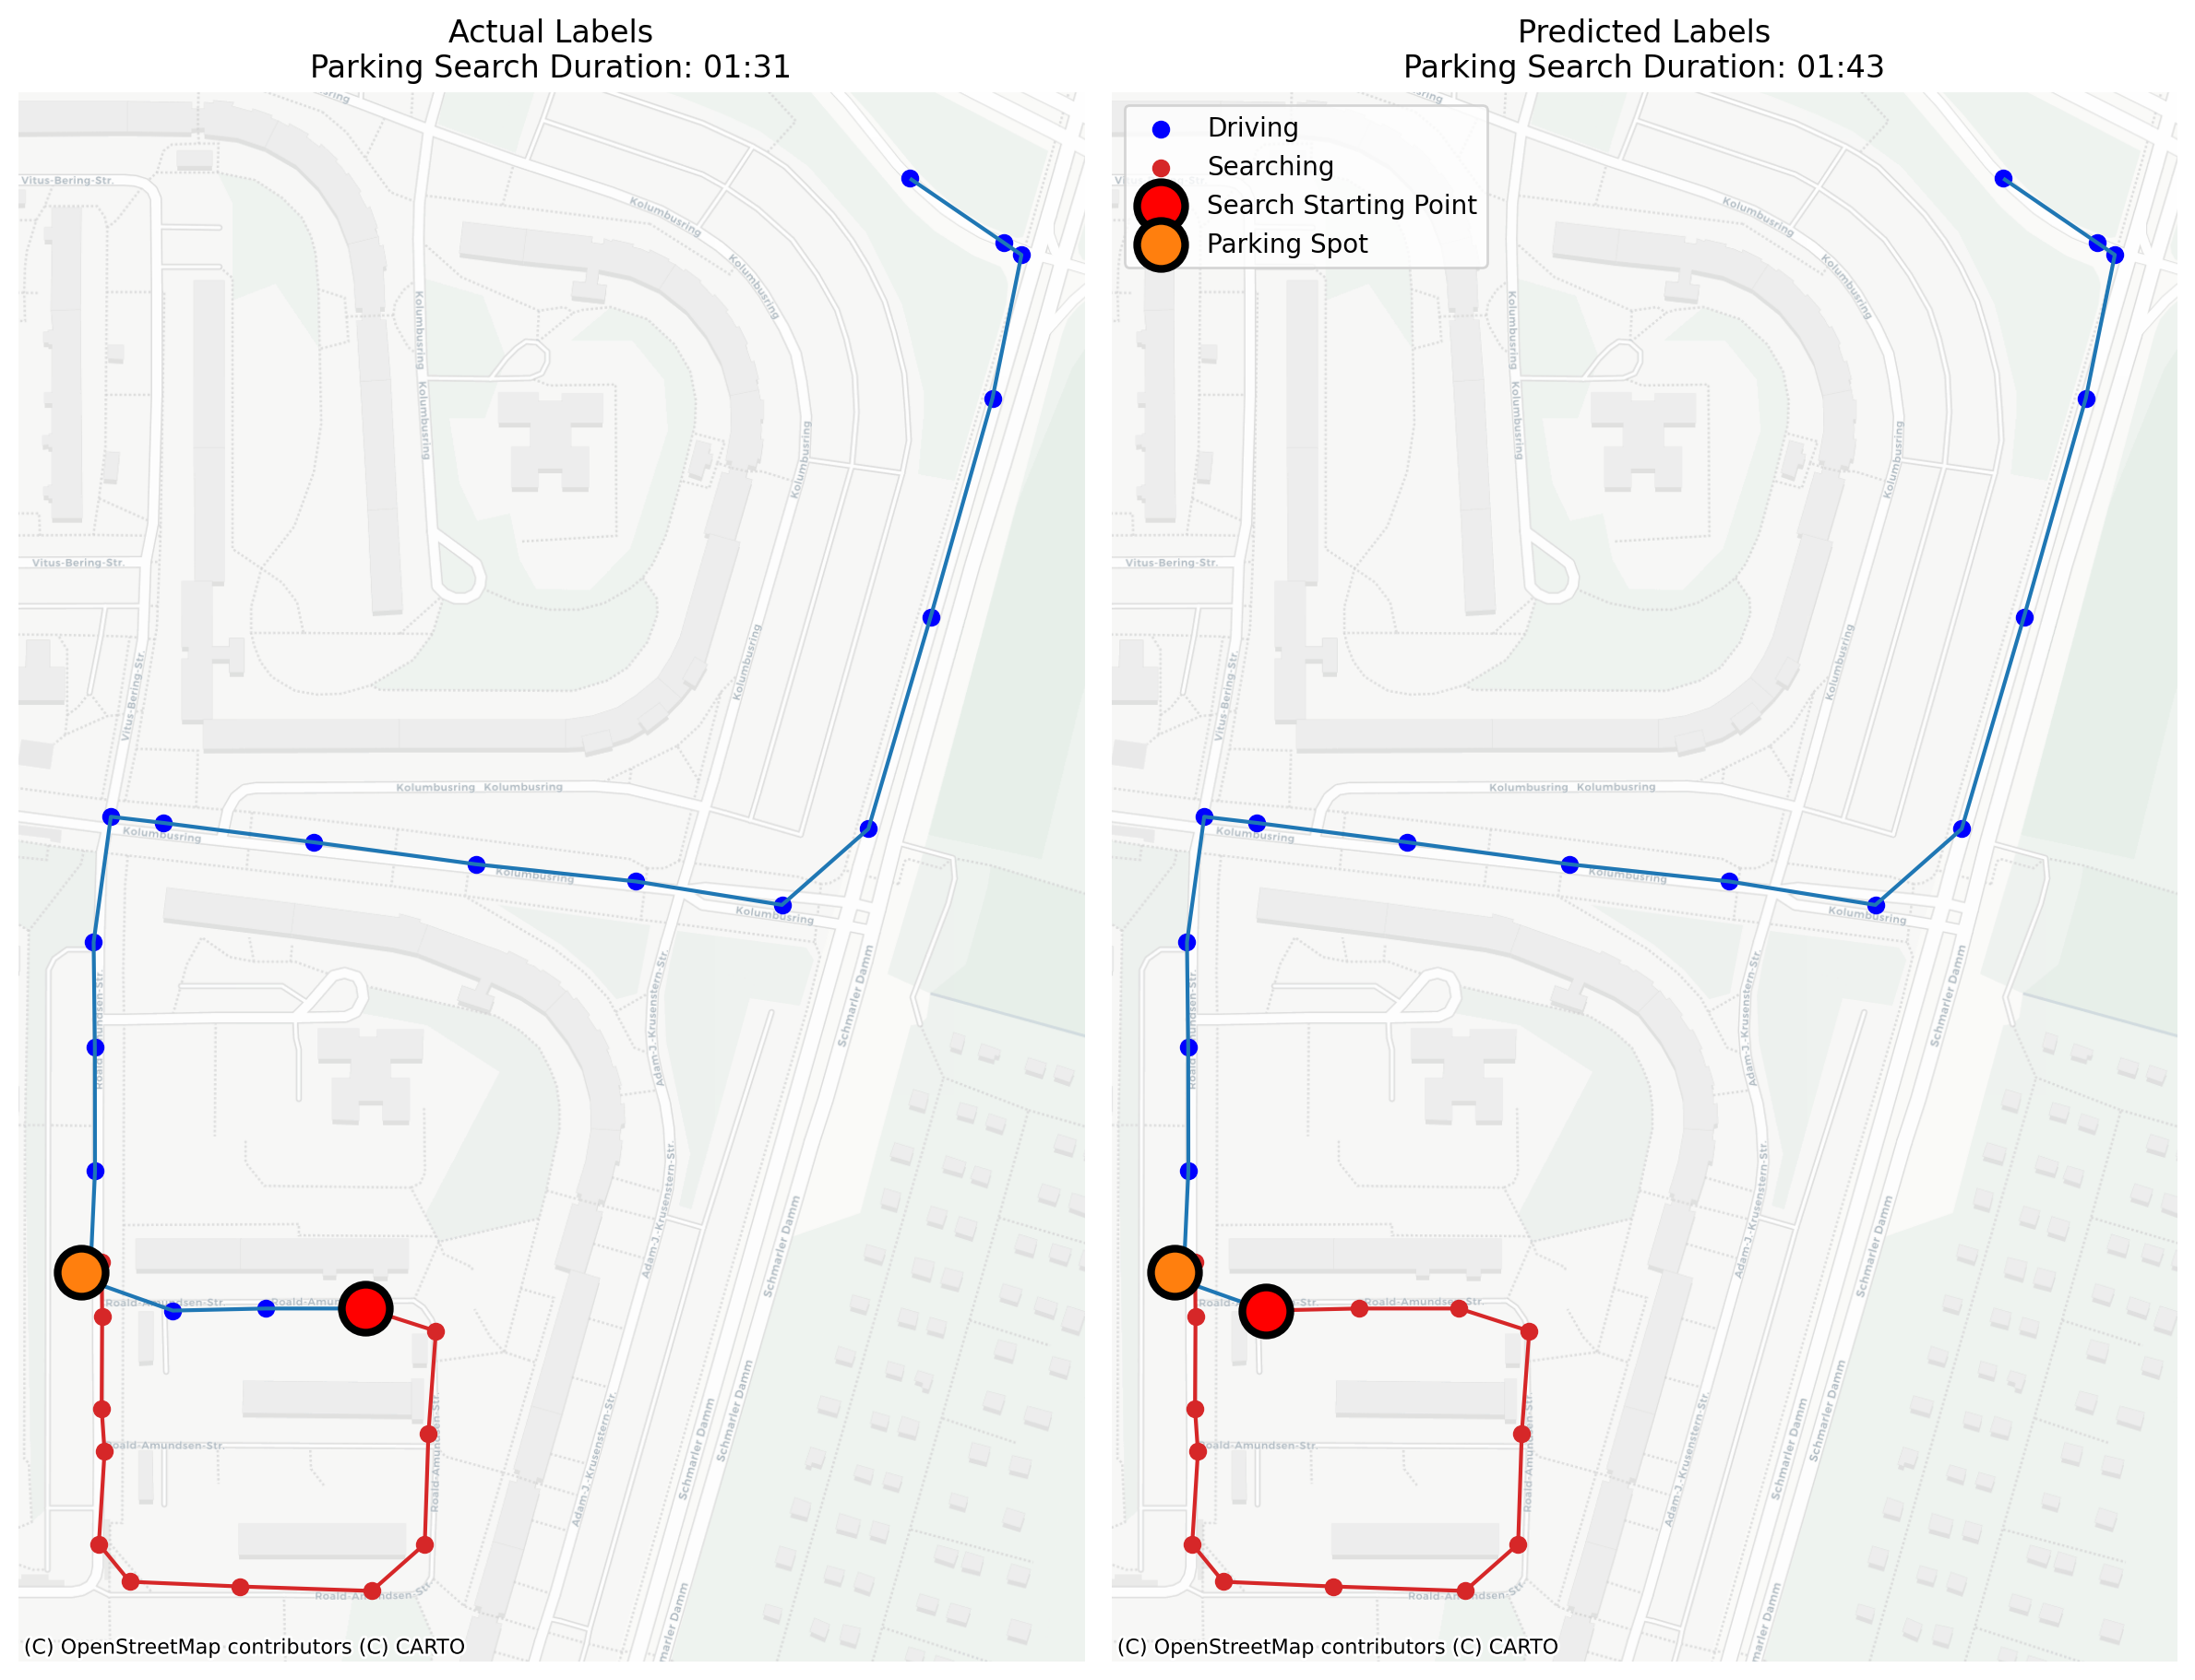

In [10]:
fig, axs = plt.subplots(1,2, figsize=(12,12), dpi=200)
plot_gps_route(axs[0], traj2_pred, n_driving_points=15, label='label', title='Actual Labels', ax_legend=False)
plot_gps_route(axs[1], traj2_pred, n_driving_points=15, label='y_hat_labels', title='Predicted Labels')
plt.tight_layout()

**Example 3:**

In [11]:
traj3_pred = park_search_predict(trajectory3, 
                                 model_path='../model/ParkingSearchPrediction.h5',
                                 col_ID=None,
                                 col_time='timestamp',
                                 col_speed='speed_kmh',
                                 col_lat='lat',
                                 col_lon='lon',
                                 verbose=1)

3/3 [==============================] - 0s 2ms/step


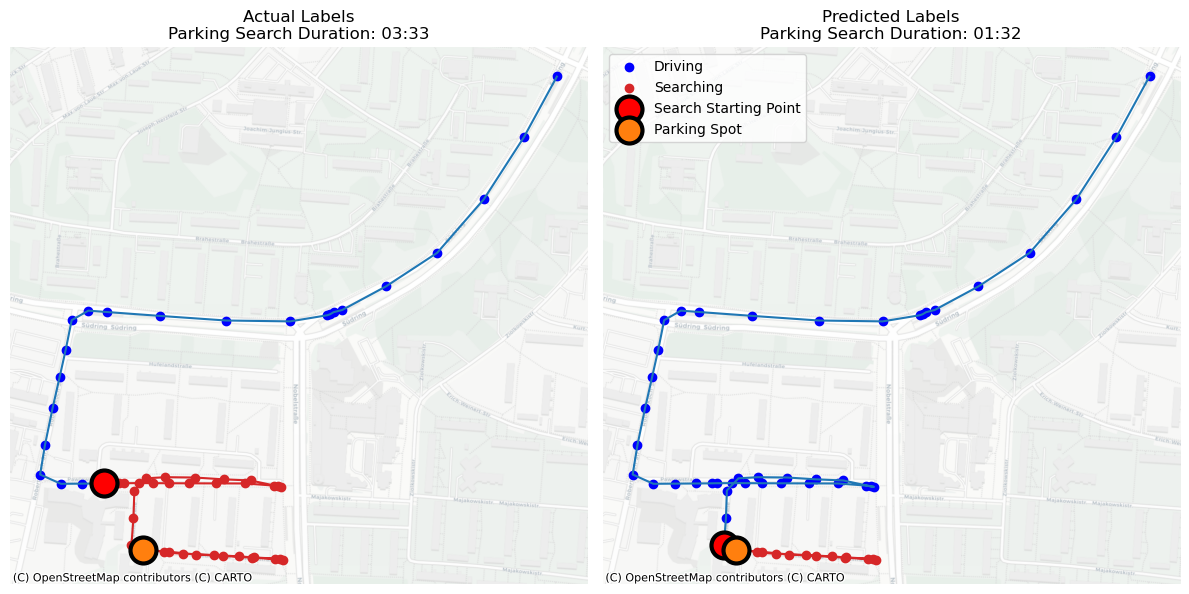

In [12]:
fig, axs = plt.subplots(1,2, figsize=(12,12), dpi=100)
plot_gps_route(axs[0], traj3_pred, n_driving_points=40, label='label', title='Actual Labels', ax_legend=False)
plot_gps_route(axs[1], traj3_pred, n_driving_points=40, label='y_hat_labels', title='Predicted Labels')
plt.tight_layout()

# Multiple Trajectories

In [13]:
trajectory1['TripID']='Trip#1'
trajectory2['TripID']='Trip#2'
trajectory3['TripID']='Trip#3'

traj_df = pd.concat([trajectory1, trajectory2, trajectory3])

In [14]:
traj_df_pred = park_search_predict(traj_df, 
                                   model_path='../model/ParkingSearchPrediction.h5',
                                   col_ID='TripID',
                                   col_time='timestamp',
                                   col_speed='speed_kmh',
                                   col_lat='lat',
                                   col_lon='lon',
                                   verbose=1)

9/9 [==============================] - 0s 2ms/step


In [15]:
traj_df_pred

lon        lat           timestamp  speed_kmh      label  TripID   
0    8.677233  50.130181 2021-02-22 20:11:11   0.000000    driving  Trip#1  \
1    8.677274  50.130207 2021-02-22 20:11:39   4.195406    driving  Trip#1   
2    8.677753  50.130292 2021-02-22 20:11:45  20.599526    driving  Trip#1   
3    8.678072  50.130509 2021-02-22 20:11:51  19.489262    driving  Trip#1   
4    8.678317  50.130747 2021-02-22 20:11:57  16.513604    driving  Trip#1   
..        ...        ...                 ...        ...        ...     ...   
86  12.114674  54.069186 2020-12-06 09:34:44  23.091536  searching  Trip#3   
87  12.114027  54.069201 2020-12-06 09:34:50  20.529928  searching  Trip#3   
88  12.113628  54.069218 2020-12-06 09:34:56  14.464292  searching  Trip#3   
89  12.113299  54.069263 2020-12-06 09:35:02   8.861314  searching  Trip#3   
90  12.113186  54.069254 2020-12-06 09:35:08   2.991041  searching  Trip#3   

    remainingTime  distToParkingSpot  samplingRate   y_hat_p y_hat_labels  
0           489.0         972.423844           0.0  0.004500      driving  
1           461.0         975.011992          28.0  0.006216      driving  
2           455.0         981.721493           6.0  0.003959      driving  
3           449.0        1004.692344           6.0  0.005176      driving  
4           443.0        1030.645062           6.0  0.005365      driving  
..            ...                ...           ...       ...          ...  
86           24.0          97.385994           6.0  0.606043    searching  
87           18.0          55.190798           6.0  0.627517    searching  
88           12.0          29.116974           6.0  0.667857    searching  
89            6.0           7.440849           6.0  0.691846    searching  
90            0.0           0.000000           6.0  0.743722    searching  

[261 rows x 11 columns]

In [16]:
visualize_trip(traj_df_pred, tripID='Trip#1', label='y_hat_labels')